<a href="https://colab.research.google.com/github/Charan619/What-should-I-watch-next/blob/master/What_Should_I_Watch_Next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **What Should I Watch Next?**                
   ### Charan K R, 18pt41, PSG College of Technology

___
##AIM:
To create a cinema recommender.  After the user types the name of a film he liked, the recommender should be able to select the top 5 movies he will enjoy.

We need to make suggestions based on:
- **popularity** 
- **content**




##**Contents**

**1. Exploration / Insights**


**2. Cleaning**

    
**3. Recommendation Engine**


**4. Conclusion: possible improvements?**

___
## 1. Exploration / Insights

 First, we define a few functions to create an interface with the new structure of the dataset.

In [ ]:
#@title Default title text
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [ ]:
from subprocess import check_output
#print(check_output(["ls", "../input/tmdb-movie-metadata/"]).decode("utf8"))

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
credits = load_tmdb_credits("/content/tmdb_5000_credits.csv")
movies = load_tmdb_movies("/content/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)
#__________________________________________
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


___
### 1.1 Keywords

To develop the recommendation engine, I plan to make an extensive use of the keywords that describe the films. Basic assumption is that films described by similar keywords should have similar contents. To do so, I first list the keywords which are in the dataset:

In [ ]:
set_keywords = set()
for list_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(list_keywords, float): continue  # only happen if list_keywords = NaN
    set_keywords = set_keywords.union(list_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

and then define a function that counts the number of times each of them appear:

In [ ]:
def count_word(df, ref_col, list):
    keyword_count = dict()
    for s in list: keyword_count[s] = 0
    for list_keywords in df[ref_col].str.split('|'):        
        if type(list_keywords) == float and pd.isnull(list_keywords): continue        
        for s in [s for s in list_keywords if s in list]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

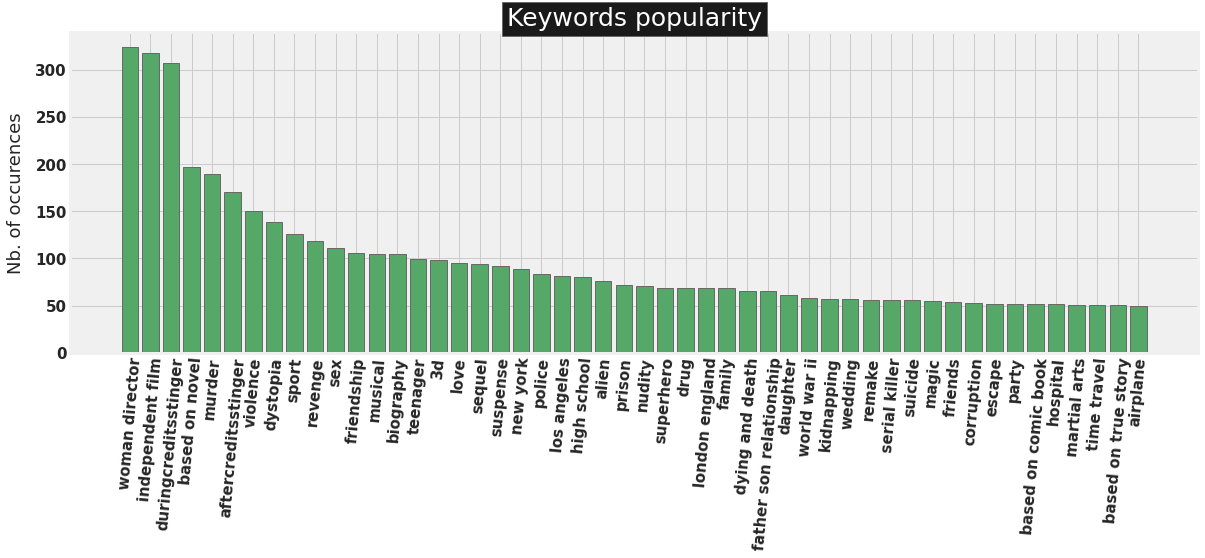

In [ ]:
#_____________________________________________
# Function that control the color of the words



fig = plt.figure(1, figsize=(18,13))
#_______________________________________________________

#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
words = dict()
trunc_occurences = keyword_occurences[0:50]
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [ ]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_initial.shape[0] 
                                - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


___
### 1.2 Number of films per year

In [ ]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()

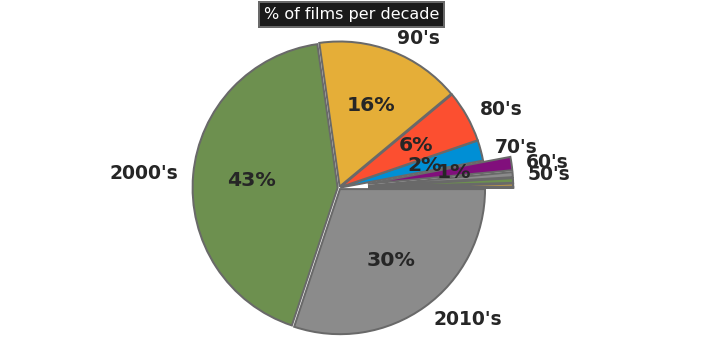

In [ ]:
sns.set_context("poster", font_scale=0.85)
def label(s):
    val = (1900 + s, s)[s < 100]
    chain = '' if s < 50 else "{}'s".format(int(val))
    return chain
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

___
### 1.3 Genres

In [ ]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

and then counting how many times each of them occur:

In [ ]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

Finally, the result is shown as a wordcloud:

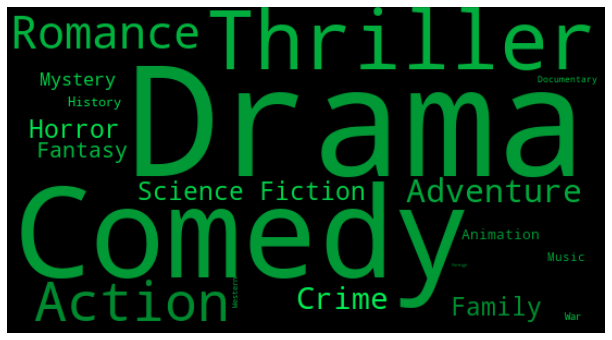

In [ ]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
## 2. Cleaning
___

In [ ]:
df_duplicate_cleaned = df_initial

___
### 2.1 Cleaning of the keywords


___
#### 2.1.1 Grouping by *roots*

I collect the keywords that appear in the **plot\_keywords** variable. This list is then cleaned using the NLTK package. Finally, I look for the number of occurence of the various keywords.

In [ ]:
# Collect the keywords
#----------------------
def keywords_inventory(dataframe, column = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k ; min_length = len(k)            
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [ ]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               column = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 9474


In [ ]:
# Plot of a sample of keywords that appear in close varieties 
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alien', 'alienation'} 2
2 {'spy', 'spying'} 2
3 {'vigilante', 'vigilantism'} 2
4 {'terror', 'terrorism'} 2
5 {'flood', 'flooding'} 2
6 {'spider', 'spiders'} 2
7 {'horses', 'horse'} 2
8 {'musical', 'music'} 2
9 {'animation', 'animal', 'anime'} 3
10 {'compass', 'compassion'} 2
11 {'train', 'training'} 2
12 {'sail', 'sailing'} 2
13 {'time traveler', 'time travel'} 2
14 {'orcs', 'orc'} 2


In [ ]:
# Replacement of the keywords by the main form
#----------------------------------------------
def replacement_df_keywords(df, dico_replacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chain = row['plot_keywords']
        if pd.isnull(chain): continue
        new_list = []
        for s in chain.split('|'): 
            key = PS.stem(s) if roots else s
            if key in dico_replacement.keys():
                new_list.append(dico_replacement[key])
            else:
                new_list.append(s)       
        df_new.at[index, 'plot_keywords']= '|'.join(new_list) 
    return df_new

In [ ]:
# Replacement of the keywords by the main keyword
#-------------------------------------------------
df_keywords_cleaned = replacement_df_keywords(df_duplicate_cleaned, keywords_select,roots = True)

In [ ]:
# Count of the keywords occurences
#----------------------------------
#keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

___
#### 2.2.2 Groups of *synonyms*

I clean the list of keywords in two steps. As a first step, I suppress the keywords that appear less that 5 times and replace them by a synomym of higher frequency. As a second step, I suppress all the keywords that appear in less than 3 films

In [ ]:
# get the synomyms of the word 'mot_cle'
#--------------------------------------------------------------
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            #_______________________________
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Example of a list of synonyms given by NLTK
#---------------------------------------------------
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "unknown                       " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "alien                         " in keywords list -> True 80
 "extraterrestrial              " in keywords list -> True 4


In [ ]:
# check if 'mot' is a key of 'key_count' with a test on the number of occurences   
#----------------------------------------------------------------------------------
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [ ]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creation of a dictionary to replace keywords by higher frequency keywords
replacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals
    #_________________________________________________________________
    list_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    list_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(list_mots) <= 1: continue       # no replacement
    if mot == list_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, list_mots[0][0], list_mots))    
    replacement_mot[mot] = list_mots[0][0]

print(90*'_'+'\n'+'The replacement happens with {}% of the keywords.'
      .format(round(len(replacement_mot)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement happens with 5.95% of the keywords.


In [ ]:
# 2 successive replacements
#---------------------------
print('Keywords synonyms replacement'.upper()+'\n'+45*'-')
icount = 0
for s in replacement_mot.values():
    if s in replacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, replacement_mot[s]))

for key, value in replacement_mot.items():
    if value in replacement_mot.keys():
        replacement_mot[key] = replacement_mot[value]

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [ ]:
# replacement of keyword varieties by the main keyword
#----------------------------------------------------------
df_keywords_synonyms = \
            replacement_df_keywords(df_keywords_cleaned, replacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, column = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8911


In [ ]:
# New count of keyword occurences
#-------------------------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [ ]:
# deletion of keywords with low frequencies
#-------------------------------------------
def replacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chain = row['plot_keywords']
        if pd.isnull(chain): continue
        new_list = []
        for s in chain.split('|'): 
            if key_count.get(s, 4) > 3: new_list.append(s)
        df_new.at[index, 'plot_keywords']='|'.join(new_list)
    return df_new

In [ ]:
# Creation of a dataframe where keywords of low frequencies are suppressed
#-------------------------------------------------------------------------
df_keywords_occurence = \
    replacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, column = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 2121


In [ ]:
# New keywords count
#-------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

___
### 2.2 Correlations

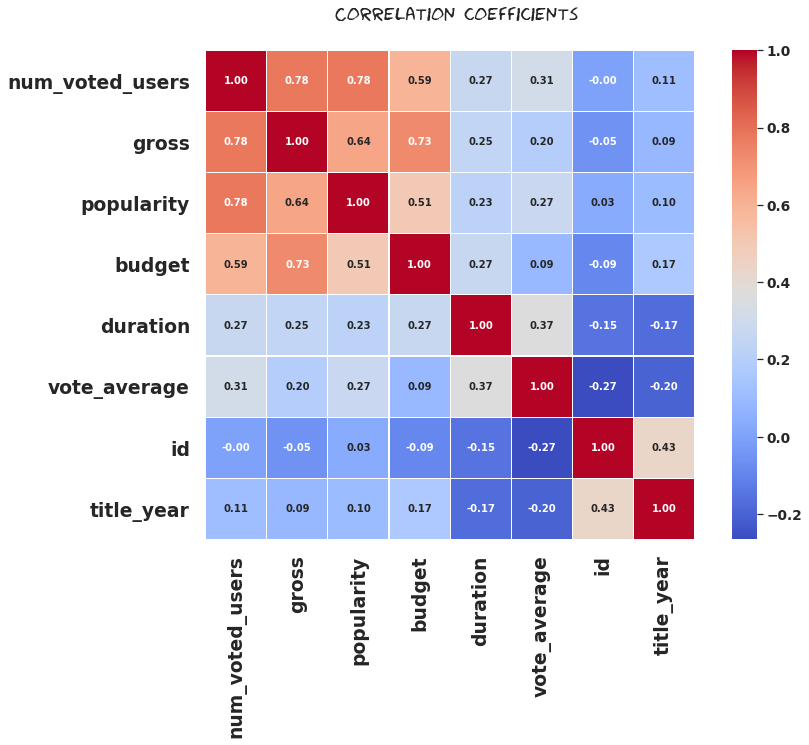

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [ ]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

___
###  2.3 Missing values
I examine the number of missing values in each variable and then choose a methodology to complete the dataset.

In [ ]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


The content of this table is now represented:

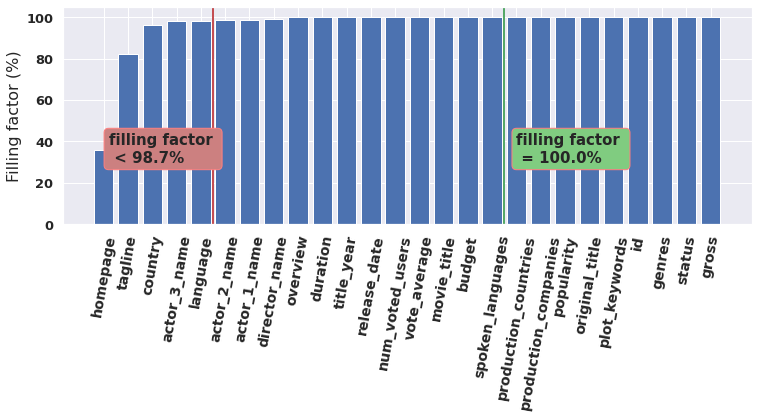

In [ ]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label, fontsize = 14 )
plt.ylabel('Filling factor (%)', fontsize = 16)
plt.bar(x_axis, y_axis);

___
#### 2.3.1 Setting missing title years

 To infer the title year, I use the list of actors and the director. For each of them, I determine the mean year of activity, using the current dataset. I then average the values obtained to estimate the title year.

In [ ]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [ ]:
df_filling.iloc[4553]

budget                                                                  0
genres                                                                   
homepage                                                              NaN
id                                                                 380097
plot_keywords                                                            
language                                                              NaN
original_title                                 America Is Still the Place
overview                1971 post civil rights San Francisco seemed li...
popularity                                                              0
production_companies                                                   []
production_countries                                                   []
release_date                                                          NaT
gross                                                                   0
duration                              

In [ ]:
def fill_year(df):
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]
    #_____________________________________________________________
    # get the mean years of activity for the actors and director
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    #_____________________________________________
    # create a dictionnary collecting this info
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
    #______________________________________
    # identification of missing title years
    missing_year_info = df[df['title_year'].isnull()]
    #___________________________
    # filling of missing values
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        icount = 0 ; sum_year = 0
        for i in range(4):            
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): icount += 1 ; sum_year += actor_year[var[i]]
        if icount != 0: sum_year = sum_year / icount 

        if int(sum_year) > 0:
            icount_replaced += 1
            df.set_value(index, 'title_year', int(sum_year))
            if icount_replaced < 10: 
                print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return

In [ ]:
fill_year(df_filling)

___
#### 2.3.2 Extracting keywords from the title

I try to fill missing values in the **plot_keywords** variable using the words of the title. To do so, I create the list of synonyms of all the words contained in the title and I check if any of these synonyms are already in the keyword list. When it is the case, I add this keyword to the entry:

In [ ]:
icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    list_mot = row['movie_title'].strip().split()
    new_keyword = []
    for s in list_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.set_value(index, 'plot_keywords', '|'.join(new_keyword))

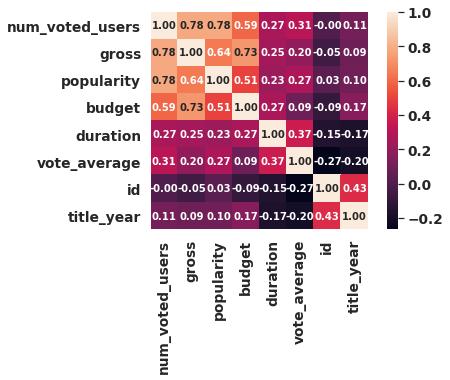

In [ ]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Finally, I examine which amount of data is still missing in the dataframe:

In [ ]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


and we can see that in the worst case, the filling factor is around 96% (excluding the **homepage** and **tagline** variables).

In [ ]:
df.head

<bound method NDFrame.head of          budget                                    genres  \
0     237000000  Action|Adventure|Fantasy|Science Fiction   
1     300000000                  Adventure|Fantasy|Action   
2     245000000                    Action|Adventure|Crime   
3     250000000               Action|Crime|Drama|Thriller   
4     260000000          Action|Adventure|Science Fiction   
...         ...                                       ...   
4798     220000                     Action|Crime|Thriller   
4799       9000                            Comedy|Romance   
4800          0             Comedy|Drama|Romance|TV Movie   
4801          0                                             
4802          0                               Documentary   

                                               homepage      id  \
0                           http://www.avatarmovie.com/   19995   
1          http://disney.go.com/disneypictures/pirates/     285   
2           http://www.sonypictures.

___
## 3. RECOMMENDATION ENGINE

___
### 3.1 Basic functioning of the engine 
 order to build the recommendation engine, I will basically proceed in two steps:
- 1/ determine $N$ films with a content similar to the entry provided by the user
- 2/ select the 5 most popular films among these $N$ films

#### 3.1.1 Similarity
We define a criteria that would tell us how close two films are. To do so, I start from the description of the film that was selected by the user: from it, I get the director name, the names of the actors and a few keywords. I then build a matrix where each row corresponds to a film of the database and where the columns correspond to the previous quantities (director + actors + keywords) plus the *k* genres


#### 3.1.2 Popularity

According to similarities between entries, we get a list of $N$ films. At this stage, I select 5 films from this list and, to do so, I give a score for every entry. I decide to compute the score according to 3 criteria:
- the IMDB score
- the number of votes the entry received
- the year of release

I assume that people's favorite films will be most of the time from the same period. I use Gaussian func to reward years that are closer to target movie exponentially more than far away ones


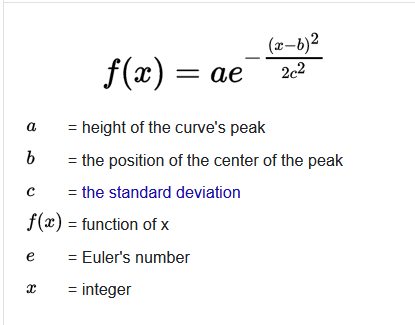

___
### 3.2 Definition of the functions

In [ ]:
gaussian_func = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [ ]:
def entry_variables(df, id_entry): 
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [ ]:
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    columns = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for category in columns:
        for index, row in df.iterrows():
            if pd.isnull(row[category]): continue
            for s in row[category].split('|'):
                if s in REF_VAR: df.at[index, s]= 1            
    return df

Creates a list of N (= 31) films similar to the film selected by the user.

In [ ]:
def recommend(df, id_entry):    
    df_copy = df.copy(deep = True)    
    list_genres = set()
    for s in df['genres'].str.split('|').values:
        list_genres = list_genres.union(set(s))    
    #_____________________________________________________
    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(list_genres)
    df_new = add_variables(df_copy, variables)
    #____________________________________________________________________________________
    # determination of the closest neighbors: the distance is calculated / new variables
    X = df_new[variables].values
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry][variables].values
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]

In [ ]:
def extract_parameters(df, list_films):     
    parameters_films = ['_' for _ in range(31)]
    i = 0
    max_users = -1
    for index in list_films:
        parameters_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'imdb_score', 'num_user_for_reviews', 
                                        'num_voted_users']])
        parameters_films[i].append(index)
        max_users = max(max_users, parameters_films[i][4] )
        i += 1
        
    title_main = parameters_films[0][0]
    year_ref  = parameters_films[0][1]
    parameters_films.sort(key = lambda x:sel_criteria(title_main, max_users,
                                    year_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parameters_films

 **Function comparing 2 film titles**: the sequel *sequel()* function compares the 2 titles passed in input and defines if these titles are similar or not.

In [ ]:
def sequel(title_1, title_2):    
    if fuzz.ratio(title_1, title_2) > 50 or fuzz.token_set_ratio(title_1, title_2) > 50:
        return True
    else:
        return False

In [ ]:
def sel_criteria(title_main, max_users, year_ref, title, year, imdb_score, votes):    
    if pd.notnull(year_ref):
        factor_1 = gaussian_func(year_ref, year, 20)
    else:
        factor_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        factor_2 = gaussian_func(votes, max_users, sigma)
    else:
        factor_2 = 0
        
    if sequel(title_main, title):
        note = 0
    else:
        note = imdb_score**2 * factor_1 * factor_2
    
    return note

In [ ]:
def add_to_selection(film_selection, parameters_films):    
    film_list = film_selection[:]
    icount = len(film_list)    
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parameters_films[i][0]: already_in_list = True
            if sequel(parameters_films[i][0], s[0]): already_in_list = True            
        if already_in_list: continue
        icount += 1
        if icount <= 6:
            film_list.append(parameters_films[i])
    return film_list

 **Function filtering sequels**: the *remove\_sequels()* function remove sequels from the list if more that two films from a series are present. The older one is kept.

In [ ]:
def remove_sequels(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list

**Main function**: create a list of 5 films that will be recommended to the user.

In [ ]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):    
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    list_films = recommend(df, id_entry)
    #__________________________________
    # Create a list of 31 films
    parameters_films = extract_parameters(df, list_films)
    #_______________________________________
    # Select 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parameters_films)
    #__________________________________
    # delation of the sequels
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    film_selection = add_to_selection(film_selection, parameters_films)
    #_____________________________________________
    selection_titles = []
    #print(film_selection)
    film_selection.pop(0)

    for i,s in enumerate(film_selection):
        selection_titles.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titles

___
### 3.3 Making meaningful recommendations

In [ ]:
!pip install pandas==0.25.3

Recommending sequels of the given movie may seem quite dumb ... eg:

In [ ]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: At World's End
nº2      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº3      -> Pirates of the Caribbean: On Stranger Tides
nº4      -> Cutthroat Island              
nº5      -> The Hobbit: An Unexpected Journey


This would be a better recommendation:


In [ ]:
dum = find_similarities(df, 12, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Cutthroat Island              
nº2      -> The Hobbit: An Unexpected Journey
nº3      -> The 13th Warrior              
nº4      -> Red Sonja                     
nº5      -> The Last Witch Hunter         


___
### 3.4 Example of recommendation: test-case

In [ ]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)
#find_similarities(df, i, del_sequels = True, verbose = True)


__________________________________________________________________________________________
QUERY: films similar to id=0 -> 'Avatar'
nº1      -> Star Trek Into Darkness       
nº2      -> Jupiter Ascending             
nº3      -> The Fifth Element             
nº4      -> Pirates of the Caribbean: On Stranger Tides
nº5      -> John Carter                   
__________________________________________________________________________________________
QUERY: films similar to id=3 -> 'The Dark Knight Rises'
nº1      -> Batman & Robin                
nº2      -> The Kingdom                   
nº3      -> The Dark Knight Rises         
nº4      -> Kick-Ass                      
nº5      -> Hitman                        
__________________________________________________________________________________________
QUERY: films similar to id=6 -> 'Tangled'
nº1      -> The Princess and the Frog     
nº2      -> Ponyo                         
nº3      -> Toy Story 3                   
nº4      -> Pino

#### Final Search Engine

In [ ]:
titles=df['original_title']
titles=titles.values.tolist()
#print(titles)
#titles.index("Titanic")

In [ ]:
mov=input("Enter the movie you like ")
i=titles.index(mov)
find_similarities(df, i, del_sequels = True, verbose = True)

Enter the movie you like Jurassic Park
__________________________________________________________________________________________
QUERY: films similar to id=675 -> 'Jurassic Park'
nº1      -> The Beast from 20,000 Fathoms 
nº2      -> Stargate: The Ark of Truth    
nº3      -> The 5th Wave                  
nº4      -> Independence Day: Resurgence  
nº5      -> A.I. Artificial Intelligence  


[['The Beast from 20,000 Fathoms', 4669],
 ['Stargate: The Ark of Truth', 3405],
 ['The 5th Wave', 1326],
 ['Independence Day: Resurgence', 91],
 ['A.I. Artificial Intelligence', 363]]

___
## 4. Conclusion: possible improvements and points to address

Finally a few things were not considered when building the engine and they should deserve some attention:
- Make movie name search more powerful
- create a list of connections between actors to see which are the actors that use to play in similar movies.
- extend the detections of sequels to films that don't share similar titles (e.g. Fast & Furious, James Bond etc)